# Conclusions

This project aims to model and predict the the mortality rate in hospitals in patients by using a 1988 dataset of patient information from the Cleveland database, which can be found on [Kaggle](https://www.kaggle.com/ronitf/heart-disease-uci) and [UC Irvine's Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease). 

The project is divided into three separate Jupyter notebooks:

1. [Exploratory Data Analysis](https://github.com/melaniewalsh/heart-disease-prediction/blob/master/Exploratory-Data-Analysis.ipynb)
2. [Modeling](https://github.com/melaniewalsh/heart-disease-prediction/blob/master/Modeling.ipynb)
3. Conclusions (below)

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [4]:
import eli5
from eli5.sklearn import PermutationImportance
import shap

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
heart = pd.read_csv(r"C:\Users\Asus\Desktop\heart-disease-prediction-master-20220110T101007Z-001\heart-disease-prediction-master\data\heart.csv")

In [7]:
heart = heart.rename(columns={"cp": "chest_pain", "trestbps": "blood_pressure", "fbs": "blood_sugar", "ca": "vessels", "chol": "cholesterol"})

In [8]:
heart_plot = pd.read_csv(r"C:\Users\Asus\Desktop\heart-disease-prediction-master-20220110T101007Z-001\heart-disease-prediction-master\data\heart.csv")
heart_plot = heart_plot.rename(columns={"cp": "chest_pain", "trestbps": "blood_pressure", "fbs": "blood_sugar", "ca": "vessels", "chol": "cholesterol"})
heart_plot['health_status'] = heart_plot['target']
heart_plot['health_status'] = ["healthy" if x == 0 else "sick" for x in heart_plot['health_status']]

In [9]:
standardScaler = StandardScaler()
columns_to_scale = ['age', 'blood_pressure', 'cholesterol', 'thalach', 'oldpeak']
heart[columns_to_scale] = standardScaler.fit_transform(heart[columns_to_scale])

In [10]:
heart = pd.get_dummies(heart, columns = ['sex', 'chest_pain', 'blood_sugar', 'restecg', 'exang', 'slope', 'thal'], drop_first=True)

In [11]:
labels = heart['target']
features = heart.drop(['target'], axis = 1)

In [12]:
features_train , features_test, labels_train, labels_test = train_test_split(features, labels, test_size= 0.2, random_state=42)

# Summary of Dataset and Objective

The 1988 Cleveland dataset contained information about 303 patients. Of these 303 patients, 165 patients exhibited the presence of heart disease, and 138 patients did not exhibit the presence of heart disease.

<AxesSubplot:xlabel='health_status', ylabel='count'>

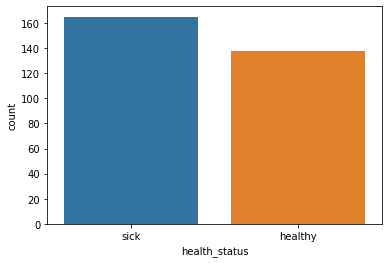

In [13]:
sns.countplot(data=heart_plot, x= 'health_status')

Based on 13 features included about each patient (listed below), I attempted to model and predict the presence of heart disease in patients more broadly. I also wanted to identify which features, in particular, might be strong indicators of heart disease:

> 1. age 
> 2. sex 
> 3. chest pain type 
> 4. resting blood pressure 
> 5. serum cholestorol in mg/dl 
> 6. fasting blood sugar > 120 mg/dl
> 7. resting electrocardiographic results 
> 8. maximum heart rate achieved 
> 9. exercise induced angina 
> 10. oldpeak = ST depression induced by exercise relative to rest 
> 11. the slope of the peak exercise ST segment 
> 12. number of major vessels colored by fluoroscopy 
> 13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect (thallium heart scan or stress test)

# Modeling and Predictions

After experimenting with four binary classification machine learning algorithms (random forest, k-nearest neighbors, logistic regression, and Naive Bayes), the algorithms that returned the most accurate heart disease predictions were **k-nearest neighbors** and **logistic regression**. Both algorithms returned an accuracy score of **90.2%**. 

However, I decided to move forward with **k-nearest neighbors** because its precision score with healthy diagnoses was higher (0.90 vs. .87). The model returned fewer false negatives, in other words: fewer false healthy diagnoses when the patients were actually sick. For this case study, I deemed that it was more dangerous to return a false negative, because the consequence could be that a sick patient does not receive the medical treatment they need. With that said, it would be advantageous to learn more about how this prediction model might actually be used in practice and other possible consequences, which would help further inform my algorithm choice.

### K Nearest Neighbors

In [14]:
knn = KNeighborsClassifier(n_neighbors = 23)
knn.fit(features_train, labels_train)
prediction = knn.predict(features_test)
score = round(knn.score(features_test, labels_test), 3) *100
print(f"K Nearest Neighbors accuracy is {score}%")

K Nearest Neighbors accuracy is 90.2%


Text(0.5, 1.0, 'K Nearest Neighbors: Confusion Matrix')

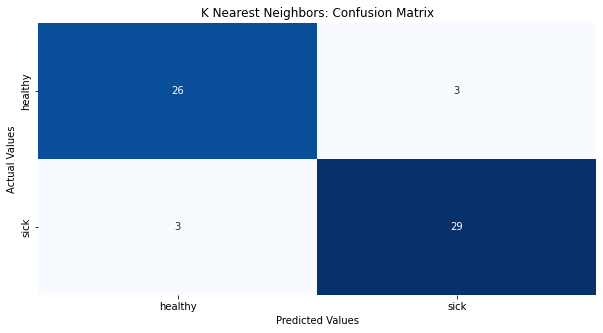

In [15]:
labels_predicted = knn.predict(features_test)
plt.subplots(figsize=(10,5))

conf_mat = confusion_matrix(labels_test, labels_predicted)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['healthy', 'sick'], yticklabels=['healthy', 'sick'])
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('K Nearest Neighbors: Confusion Matrix')

As demonstrated in the confusion matrix above, the model accurately predicted 29 patients who exhibited heart disease and 26 patients who did not exhibit heart disease (out of 61 total test patients). However, the model incorrectly predicted that 3 patients exhibited heart disease when in actuality they did not and 3 patients that did not exhibit heart disease when in actuality they did.

In [16]:
print(classification_report(labels_test, labels_predicted, target_names = ['healthy', 'sick']))

              precision    recall  f1-score   support

     healthy       0.90      0.90      0.90        29
        sick       0.91      0.91      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



In [17]:
precision = (round(26/29, 2))           
print(f"The precision score for a healthy diagnosis is {precision}")

The precision score for a healthy diagnosis is 0.9


# Feature Importance

After successfully creating a model to predict mortality, I next attempted to identify features that might be strong indicators of any disease.

In [18]:
perm = PermutationImportance(knn, random_state=42).fit(features_test, labels_test)
eli5.show_weights(perm, feature_names = features_test.columns.tolist())

Weight,Feature
0.0459 ± 0.0636,vessels
0.0426 ± 0.0334,thalach
0.0361 ± 0.0321,oldpeak
0.0262 ± 0.0262,blood_pressure
0.0262 ± 0.0161,cholesterol
0.0262 ± 0.0262,exang_1
0.0230 ± 0.0262,chest_pain_3
0.0197 ± 0.0382,thal_3
0.0197 ± 0.0131,restecg_1
0.0197 ± 0.0245,age


As determined by the permutation importance algorithm above, some of the features that would be worth further exploring as potentially strong indicators of heart disease include: the number of vessels colored by a fluoroscopy, thalach, oldpeak, blood pressure, cholesterol, and chest pain.

# Looking Forward

To produce an even more accurate heart disease prediction model, it would be helpful to obtain a larger dataset as well as a more recent dataset, since the dataset used in this project was created in 1988. There are almost certainly medical tests and metrics developed over the last 30 years that would help further improve our identification of heart disease.